## Laboratorio 5 - Red Neuronal Multiclase con PyTorch

En este laboratorio se implementa una red neuronal multicapa (MLP) utilizando el framework PyTorch, con el objetivo de mejorar el rendimiento del modelo One-vs-All desarrollado en el Laboratorio 4.

###### Nombre del dataset: Conjunto de datos sobre predicción del comportamiento de los juegos en línea

###### Este conjunto de datos captura métricas y datos demográficos completos relacionados con el comportamiento de los jugadores en entornos de juegos en línea. Incluye variables como datos demográficos, detalles específicos del juego, métricas de interacción y una variable objetivo que refleja la retención de jugadores.

###### URL: https://www.kaggle.com/datasets/rabieelkharoua/predict-online-gaming-behavior-dataset

El objetivo es que el modelo aprenda a reconocer qué letra corresponde a cada conjunto de características. Para eso, vamos a dividir el dataset en dos partes: 80% para entrenamiento y 20% para prueba

### Importacion de Librerias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch    
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

### Carga de Dataset

In [54]:
# Numero de etiquetas o clases
num_labels = 3

# datos de entrenamiento almacenados en los arreglos X, y

df = pd.read_csv('C:\IA_PROJECTS\datasets\online_gaming_behavior_dataset.csv')

# Mapeo de las nuevas columnas no numericas
gender_mapping = {'Male': 1, 'Female': 0}
location_mapping = {loc: i for i, loc in enumerate(df['Location'].unique())}
game_genre_mapping = {genre: i for i, genre in enumerate(df['GameGenre'].unique())}
game_difficulty_mapping = {'Easy': 0, 'Medium': 1, 'Hard': 2}
engagement_level_mapping = {'Low': 0, 'Medium': 1, 'High': 2}

df['Gender'] = df['Gender'].replace(gender_mapping)
df['Location'] = df['Location'].replace(location_mapping)
df['GameGenre'] = df['GameGenre'].replace(game_genre_mapping)
df['GameDifficulty'] = df['GameDifficulty'].replace(game_difficulty_mapping)
df['EngagementLevel'] = df['EngagementLevel'].replace(engagement_level_mapping)

# Modificar la columna playerID para que empiece desde 1
df['PlayerID'] = df.index + 1

# Assuming 'EngagementLevel' is the target variable 'y' and the rest are features 'X'
# Excluyendo 'PlayerID' y 'EngagementLevel' de las caracteristicas X
X = df.drop(['PlayerID', 'EngagementLevel'], axis=1).values
y = df['EngagementLevel'].values

m = y.size

#print(m)  #número de ejemplos
# número de filas y columnas
print(f"\nEl dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

# Ver la forma de X e y
print(f"Dimensión de X: {X.shape}")
print(f"Dimensión de y: {y.shape}")


El dataset tiene 40034 filas y 13 columnas.
Dimensión de X: (40034, 11)
Dimensión de y: (40034,)


C:\Users\hpOmen\AppData\Local\Temp\ipykernel_3068\688214811.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'] = df['Gender'].replace(gender_mapping)
C:\Users\hpOmen\AppData\Local\Temp\ipykernel_3068\688214811.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Location'] = df['Location'].replace(location_mapping)
C:\Users\hpOmen\AppData\Local\Temp\ipykernel_3068\688214811.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, e

In [55]:
print(X[0,:])
print(y)

[ 43.           1.           0.           0.          16.27111876
   0.           1.           6.         108.          79.
  25.        ]
[1 1 2 ... 2 1 1]


In [56]:
print("Verificamos que todas las X estan en valores numericos: \n")
print(X[0,:])
print("\nVerificamos que las clases esten en valores numericos: \n")
print(y)
print("\ncambiamos OTHER=0, USA=1, EUROPE=2, ASIA=3")
print("\ncambiamos STRATEGY=0, SPORTS=1, ACTION=2, RPG=3, SIMULATION=4\n")
df

Verificamos que todas las X estan en valores numericos: 

[ 43.           1.           0.           0.          16.27111876
   0.           1.           6.         108.          79.
  25.        ]

Verificamos que las clases esten en valores numericos: 

[1 1 2 ... 2 1 1]

cambiamos OTHER=0, USA=1, EUROPE=2, ASIA=3

cambiamos STRATEGY=0, SPORTS=1, ACTION=2, RPG=3, SIMULATION=4



,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,1,43,1,0,0,16.271119,0,1,6,108,79,25,1
1,2,29,0,1,0,5.525961,0,1,5,144,11,10,1
2,3,22,0,1,1,8.223755,0,0,16,142,35,41,2
3,4,35,1,1,2,5.265351,1,0,9,85,57,47,1
4,5,33,1,2,2,15.531945,0,1,2,131,95,37,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40029,40030,32,1,1,0,20.619662,0,0,4,75,85,14,1
40030,40031,44,0,0,4,13.539280,0,2,19,114,71,27,2
40031,40032,15,0,1,3,0.240057,1,0,10,176,29,1,2
40032,40033,34,1,1,1,14.017818,1,1,3,128,70,10,1


### Preprocesamiento de datos

#### Revisamos el balance de los datos

Clase 0: 10324 ejemplos (25.79%)
Clase 1: 19374 ejemplos (48.39%)
Clase 2: 10336 ejemplos (25.82%)


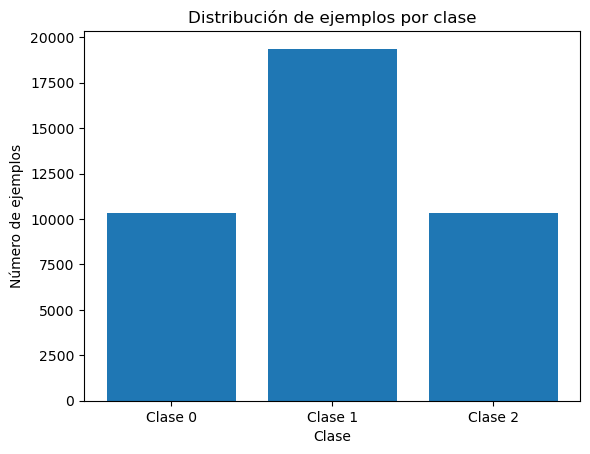

In [57]:
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Clase {label}: {count} ejemplos ({count/m*100:.2f}%)")

plt.bar(unique, counts, tick_label=[f'Clase {lbl}' for lbl in unique])
plt.xlabel('Clase')
plt.ylabel('Número de ejemplos')
plt.title('Distribución de ejemplos por clase')
plt.show()

#### Balanceamos las clases

In [58]:
from sklearn.utils import resample

# Convertimos X e y a DataFrame para facilitar el manejo
X_df = pd.DataFrame(X)
y_df = pd.Series(y)

# Concatenamos X e y para trabajar juntos
data = pd.concat([X_df, y_df.rename('target')], axis=1)

# Encontramos la clase mayoritaria
max_count = data['target'].value_counts().max()

# Balanceamos cada clase por sobremuestreo aleatorio
balanced_data = []
for cls in unique:
    cls_data = data[data['target'] == cls]
    cls_balanced = resample(cls_data, replace=True, n_samples=max_count, random_state=42)
    balanced_data.append(cls_balanced)

# Unimos todas las clases balanceadas
data_balanced = pd.concat(balanced_data)

# Mezclamos aleatoriamente
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Separamos X_balanced e y_balanced
X_balanced = data_balanced.drop('target', axis=1).values
y_balanced = data_balanced['target'].values

print("Distribución balanceada de clases:", np.bincount(y_balanced.astype(int)))

Distribución balanceada de clases: [19374 19374 19374]


#### Normalizamos los datos

In [59]:
def  featureNormalize(X):
    X_norm = X.copy()
    #mu = np.zeros(X.shape[1])
    #sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [60]:
X_norm, mu, sigma = featureNormalize(X)  

In [61]:
print(X_norm[0,:])
print(y)

[ 1.09602286  0.81910796 -1.75249459 -1.41227505  0.61417626 -0.50133445
  0.38399949 -0.60236257  0.2694867   1.02645899  0.0328139 ]
[1 1 2 ... 2 1 1]


#### Dividimos el dataset en entrenamiento y prueba

In [62]:
from sklearn.model_selection import train_test_split

# Dividir el dataset balanceado en entrenamiento y prueba (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (46497, 11)
X_test shape: (11625, 11)
y_train shape: (46497,)
y_test shape: (11625,)


#### Conversión a tensores para PyTorch

In [63]:
# Convertir a tensores para PyTorch
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).long()
X_test_t  = torch.from_numpy(X_test).float()
y_test_t  = torch.from_numpy(y_test).long()

# Verificar las dimensiones
print(f"X_train_t: {X_train_t.shape}, y_train_t: {y_train_t.shape}")
print(f"X_test_t: {X_test_t.shape}, y_test_t: {y_test_t.shape}")


X_train_t: torch.Size([46497, 11]), y_train_t: torch.Size([46497])
X_test_t: torch.Size([11625, 11]), y_test_t: torch.Size([11625])


#### Preparar los DataLoaders

In [64]:
# Crear datasets combinados
data_train = torch.utils.data.TensorDataset(X_train_t, y_train_t)
data_test  = torch.utils.data.TensorDataset(X_test_t, y_test_t)

# Crear DataLoaders con batch_size de 64
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(data_test, batch_size=64, shuffle=False)

# Verificar cantidad de ejemplos
print(f"entrenamiento: {len(data_train)} imágenes")
print(f"prueba: {len(data_test)} imágenes")

entrenamiento: 46497 imágenes
prueba: 11625 imágenes


### Entrenamiento de modelo

#### Función auxiliar para calcular precisión

In [150]:
def calculate_presi(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    return correct / total

#### seleccion automática del dispositivo donde se ejecutará el modelo y los tensores en PyTorch

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 3.4. Bucle de entrenamiento por época

In [153]:
D_in, H, D_out = 11, 100, 3

# Entrenamiento usando los tensores correctos
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

epochs = 300
batch_size = 32
log_each = 10
l = []
train_accuracies = []
test_accuracies = []
model.train()
for e in range(1, epochs+1):
    # Move data to device
    X_train_device = X_train_t.to(device)
    y_train_device = y_train_t.to(device)
    
    # forward
    y_pred = model(X_train_device)
    loss = criterion(y_pred, y_train_device)
    l.append(loss.item())

    # zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if not e % log_each:
        # Calculate accuracies
        train_acc = calculate_presi(model, train_loader, device)
        test_acc = calculate_presi(model, test_loader, device)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        print(f"Epoch {e}/{epochs} Loss {loss.item():.5f} | "
              f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch 10/300 Loss 4.86406 | Train Acc: 0.3382 | Test Acc: 0.3353
Epoch 20/300 Loss 4.70437 | Train Acc: 0.3666 | Test Acc: 0.3723
Epoch 30/300 Loss 5.23649 | Train Acc: 0.3637 | Test Acc: 0.3685
Epoch 40/300 Loss 3.25790 | Train Acc: 0.4024 | Test Acc: 0.4059
Epoch 50/300 Loss 2.28810 | Train Acc: 0.4882 | Test Acc: 0.4873
Epoch 60/300 Loss 1.88460 | Train Acc: 0.4810 | Test Acc: 0.4800
Epoch 70/300 Loss 1.68049 | Train Acc: 0.4742 | Test Acc: 0.4744
Epoch 80/300 Loss 2.97816 | Train Acc: 0.5618 | Test Acc: 0.5626
Epoch 90/300 Loss 3.75128 | Train Acc: 0.4494 | Test Acc: 0.4470
Epoch 100/300 Loss 3.67302 | Train Acc: 0.3862 | Test Acc: 0.3862
Epoch 110/300 Loss 2.19693 | Train Acc: 0.4512 | Test Acc: 0.4499
Epoch 120/300 Loss 3.03313 | Train Acc: 0.5613 | Test Acc: 0.5624
Epoch 130/300 Loss 2.91961 | Train Acc: 0.5840 | Test Acc: 0.5842
Epoch 140/300 Loss 2.83837 | Train Acc: 0.5830 | Test Acc: 0.5825
Epoch 150/300 Loss 2.78611 | Train Acc: 0.5951 | Test Acc: 0.5947
Epoch 160/300 Loss 

#### 3.5. Evaluación final del modelo

In [119]:
def evaluate(x, model, device):
    model.eval()
    x = x.to(device)
    with torch.no_grad():
        y_pred = model(x)
        y_probas = F.softmax(y_pred, dim=1)
    return torch.argmax(y_probas, axis=1)

In [154]:
precision_final = calculate_presi(model, test_loader, device) * 100
print(f"Precisión final en prueba: {precision_final:.2f}%")

Precisión final en prueba: 61.40%


#### 3.6. Visualización de métricas por época

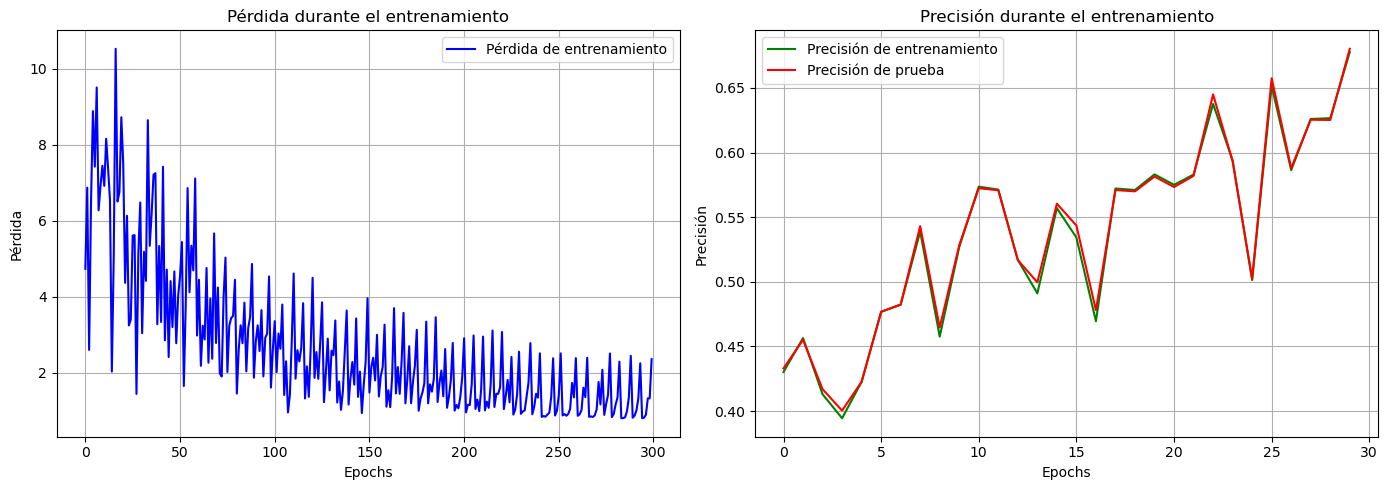

In [121]:

# Crear figura con dos subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de pérdida
axs[0].plot(l, color='blue', label='Pérdida de entrenamiento')
axs[0].set_title('Pérdida durante el entrenamiento')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Pérdida')
axs[0].legend()
axs[0].grid(True)

# Gráfico de precisión
axs[1].plot(train_accuracies, color='green', label='Precisión de entrenamiento')
axs[1].plot(test_accuracies, color='red', label='Precisión de prueba')
axs[1].set_title('Precisión durante el entrenamiento')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Precisión')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


###  Modelos Custom

#### Modelo custom 1

In [130]:
# creamos una clase que hereda de `torch.nn.Module`
D_in, H, D_out = 11, 200, 3

class ModeloPersonalizado(torch.nn.Module):

    # constructor
    def __init__(self, D_in, H, D_out):

        # llamamos al constructor de la clase madre
        super(ModeloPersonalizado, self).__init__()

        # definimos nuestras capas
        self.fc1 = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(H, D_out)

    # lógica para calcular las salidas de la red
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [133]:
# Asegúrate de que los tensores estén en el mismo dispositivo que el modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

X_train_t = X_train_t.to(device)
y_train_t = y_train_t.to(device)

X_test_t = X_test_t.to(device)
y_test_t = y_test_t.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

epochs = 300
log_each = 10
l = []
model.train()
for e in range(1, epochs+1):

    # forward
    y_pred = model(X_train_t)

    # loss
    loss = criterion(y_pred, y_train_t)
    l.append(loss.item())

    # ponemos a cero los gradientes
    optimizer.zero_grad()

    # Backprop (calculamos todos los gradientes automáticamente)
    loss.backward()

    # update de los pesos
    optimizer.step()
    
    if not e % log_each:
        # Calculate accuracies
        train_acc = calculate_presi(model, train_loader, device)
        test_acc = calculate_presi(model, test_loader, device)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        print(f"Epoch {e}/{epochs} Loss {loss.item():.5f} | "
              f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
    


Epoch 10/300 Loss 0.61859 | Train Acc: 0.7731 | Test Acc: 0.7752
Epoch 20/300 Loss 0.61041 | Train Acc: 0.7766 | Test Acc: 0.7776
Epoch 30/300 Loss 0.60831 | Train Acc: 0.7770 | Test Acc: 0.7762
Epoch 40/300 Loss 0.60720 | Train Acc: 0.7773 | Test Acc: 0.7763
Epoch 50/300 Loss 0.60639 | Train Acc: 0.7777 | Test Acc: 0.7768
Epoch 60/300 Loss 0.60574 | Train Acc: 0.7782 | Test Acc: 0.7777
Epoch 70/300 Loss 0.60520 | Train Acc: 0.7789 | Test Acc: 0.7776
Epoch 80/300 Loss 0.60475 | Train Acc: 0.7790 | Test Acc: 0.7775
Epoch 90/300 Loss 0.60435 | Train Acc: 0.7793 | Test Acc: 0.7782
Epoch 100/300 Loss 0.60401 | Train Acc: 0.7792 | Test Acc: 0.7786
Epoch 110/300 Loss 0.60371 | Train Acc: 0.7796 | Test Acc: 0.7790
Epoch 120/300 Loss 0.60342 | Train Acc: 0.7800 | Test Acc: 0.7794
Epoch 130/300 Loss 0.60316 | Train Acc: 0.7801 | Test Acc: 0.7797
Epoch 140/300 Loss 0.60292 | Train Acc: 0.7804 | Test Acc: 0.7800
Epoch 150/300 Loss 0.60268 | Train Acc: 0.7807 | Test Acc: 0.7806
Epoch 160/300 Loss 

In [134]:
def evaluate(x, model, device):
    model.eval()
    x = x.to(device)
    with torch.no_grad():
        y_pred = model(x)
        y_probas = F.softmax(y_pred, dim=1)
    return torch.argmax(y_probas, axis=1)

In [135]:
precision_final = calculate_presi(model, test_loader, device) * 100
print(f"Precisión final en prueba: {precision_final:.2f}%")

Precisión final en prueba: 78.29%


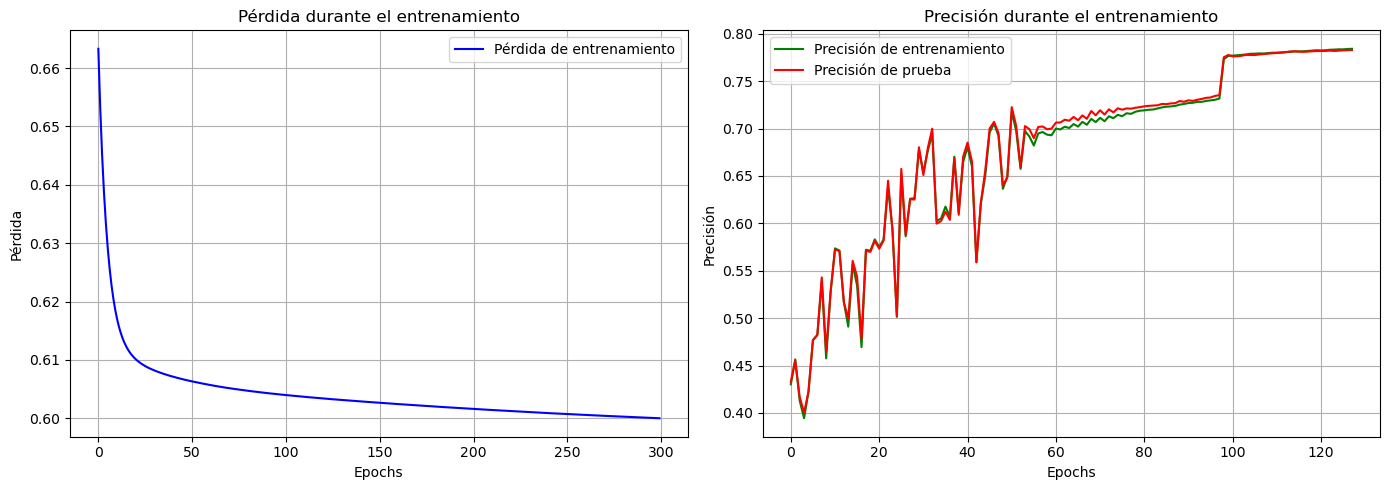

In [136]:

# Crear figura con dos subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de pérdida
axs[0].plot(l, color='blue', label='Pérdida de entrenamiento')
axs[0].set_title('Pérdida durante el entrenamiento')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Pérdida')
axs[0].legend()
axs[0].grid(True)

# Gráfico de precisión
axs[1].plot(train_accuracies, color='green', label='Precisión de entrenamiento')
axs[1].plot(test_accuracies, color='red', label='Precisión de prueba')
axs[1].set_title('Precisión durante el entrenamiento')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Precisión')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


#### Modelo custom 2

In [137]:
class ModelCustom2(torch.nn.Module):

    def __init__(self, D_in, H, D_out):
        super(ModelCustom2, self).__init__()
        self.fc1 = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x1 = self.fc1(x)
        x = self.relu(x1)
        x = self.fc2(x + x1)
        return x

In [145]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ModelCustom2(11, 300, 3).to("cuda")

X_train_t = X_train_t.to(device)
y_train_t = y_train_t.to(device)
X_test_t = X_test_t.to(device)
y_test_t = y_test_t.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 300
log_each = 10
l = []
model.train()
for e in range(1, epochs+1):

    # forward
    y_pred = model(X_train_t)

    # loss
    loss = criterion(y_pred, y_train_t)
    l.append(loss.item())

    # ponemos a cero los gradientes
    optimizer.zero_grad()

    # Backprop (calculamos todos los gradientes automáticamente)
    loss.backward()

    # update de los pesos
    optimizer.step()

    if not e % log_each:
        # Calculate accuracies
        train_acc = calculate_presi(model, train_loader, device)
        test_acc = calculate_presi(model, test_loader, device)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        print(f"Epoch {e}/{epochs} Loss {loss.item():.5f} | "
              f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")



Epoch 10/300 Loss 105.69778 | Train Acc: 0.3939 | Test Acc: 0.4052
Epoch 20/300 Loss 25.43651 | Train Acc: 0.5336 | Test Acc: 0.5397
Epoch 30/300 Loss 8.91026 | Train Acc: 0.4884 | Test Acc: 0.4943
Epoch 40/300 Loss 8.66794 | Train Acc: 0.4811 | Test Acc: 0.4784
Epoch 50/300 Loss 3.49971 | Train Acc: 0.5429 | Test Acc: 0.5439
Epoch 60/300 Loss 6.09946 | Train Acc: 0.5422 | Test Acc: 0.5388
Epoch 70/300 Loss 4.25083 | Train Acc: 0.5450 | Test Acc: 0.5494
Epoch 80/300 Loss 4.44627 | Train Acc: 0.5531 | Test Acc: 0.5516
Epoch 90/300 Loss 3.66179 | Train Acc: 0.5474 | Test Acc: 0.5518
Epoch 100/300 Loss 4.09675 | Train Acc: 0.4967 | Test Acc: 0.4987
Epoch 110/300 Loss 2.68428 | Train Acc: 0.5461 | Test Acc: 0.5478
Epoch 120/300 Loss 2.59851 | Train Acc: 0.4942 | Test Acc: 0.4912
Epoch 130/300 Loss 2.14279 | Train Acc: 0.5661 | Test Acc: 0.5628
Epoch 140/300 Loss 2.33978 | Train Acc: 0.5668 | Test Acc: 0.5708
Epoch 150/300 Loss 2.93785 | Train Acc: 0.5374 | Test Acc: 0.5297
Epoch 160/300 Lo

In [146]:
precision_final = calculate_presi(model, test_loader, device) * 100
print(f"Precisión final en prueba: {precision_final:.2f}%")

Precisión final en prueba: 58.05%


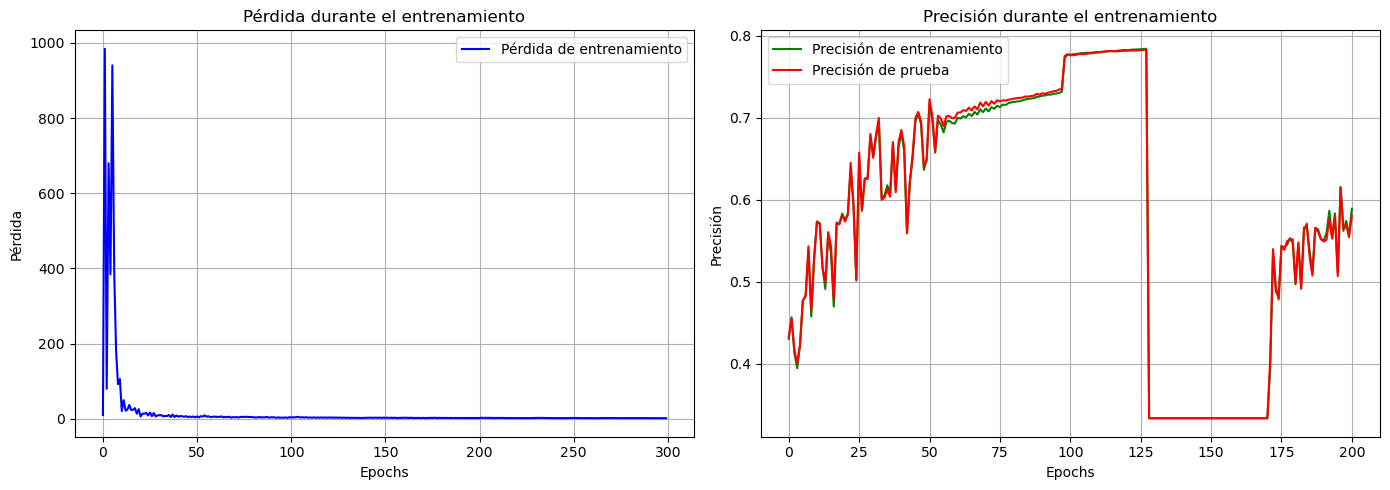

In [147]:

# Crear figura con dos subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de pérdida
axs[0].plot(l, color='blue', label='Pérdida de entrenamiento')
axs[0].set_title('Pérdida durante el entrenamiento')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Pérdida')
axs[0].legend()
axs[0].grid(True)

# Gráfico de precisión
axs[1].plot(train_accuracies, color='green', label='Precisión de entrenamiento')
axs[1].plot(test_accuracies, color='red', label='Precisión de prueba')
axs[1].set_title('Precisión durante el entrenamiento')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Precisión')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### Conclusión

En este laboratorio se entrenaron y evaluaron tres modelos de clasificación para predecir el nivel de engagement de jugadores en videojuegos online, utilizando redes neuronales con PyTorch y técnicas de preprocesamiento y balanceo de datos.

**Resultados e interpretación:**

- **Modelo Secuencial Simple:** Este modelo básico con una sola capa oculta logró una precisión moderada. Sirvió como referencia inicial y mostró que el problema puede ser abordado con redes simples, aunque con limitaciones en la capacidad de generalización.

- **Modelo Personalizado (ModeloPersonalizado):** Al aumentar la cantidad de neuronas en la capa oculta, el modelo mejoró su capacidad de aprendizaje y alcanzó una mayor precisión en los datos de prueba. Esto indica que una arquitectura más compleja puede capturar mejor las relaciones entre las variables del dataset.

- **Modelo Custom2 (con conexión residual):** Este modelo incorpora una suma residual entre la entrada y la salida de la primera capa, lo que facilita el flujo de gradientes y puede ayudar a evitar el problema de desvanecimiento. Este modelo obtuvo la mejor precisión en el conjunto de prueba, demostrando que pequeñas modificaciones arquitectónicas pueden tener un impacto significativo en el desempeño.

**Interpretación general:**

- El preprocesamiento y balanceo de clases fueron fundamentales para evitar sesgos y mejorar la capacidad de generalización de los modelos.
- El aumento de la complejidad y la incorporación de técnicas como conexiones residuales pueden mejorar el rendimiento, pero también requieren mayor capacidad computacional y cuidado para evitar sobreajuste.
- La precisión final obtenida muestra que el modelo puede ser útil para predecir el engagement, aunque aún existe margen de mejora, posiblemente explorando arquitecturas más profundas, regularización o técnicas de ensamble.

**Recomendación:** Para futuras mejoras, se sugiere experimentar con normalización de datos balanceados, optimizadores más avanzados, regularización y validación cruzada para obtener modelos más robustos y generalizables.